Using backend: pytorch


  NumNodes: 19717
  NumEdges: 88651
  NumFeats: 500
  NumClasses: 3
  NumTrainingSamples: 60
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
e_num=108365; v_num=19717
Convert a graph into a bidirected graph: 0.004 seconds
Construct multi-constraint weights: 0.000 seconds
Metis partitioning: 0.023 seconds
nodes distribution (array([5766, 5535, 3697, 4719]), array([-0.5,  0.5,  1.5,  2.5,  3.5]))


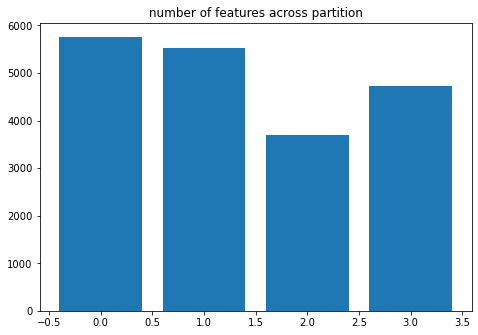

In [2]:
import dgl
from collections import OrderedDict
from random import randint
from random import sample
from random import seed
import random
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
partition_num = 4
cpu_num = os.cpu_count()
# ------ Configuration ------
dataset = dgl.data.PubmedGraphDataset()
# dataset = dgl.data.CoraGraphDataset()
# dataset = dgl.data.CiteseerGraphDataset()
## Start 

graph = dataset[0] 
graph = dgl.remove_self_loop(graph)
graph = dgl.add_self_loop(graph)
print(f"e_num={graph.num_edges()}; v_num={graph.num_nodes()}")
v2idx = dgl.metis_partition_assignment(graph, partition_num, balance_edges=True)
hist = np.histogram(v2idx, bins=np.arange(partition_num + 1) - 0.5)
print("nodes distribution", hist)
fig = plt.figure()
ax1 = fig.add_axes([0,0,1,1])
x = np.arange(partition_num)
y = hist[0]
ax1.set_title(" number of features across partition ")
ax1.bar(x, y)
plt.show()

### Helper Functions

In [3]:
def print_results(n_jobs, save_file_name=None):
    files = glob("tmp/*.npy")
    files.sort()
    max_workload_percent = []
    for i in range(n_jobs):
        file = files[i]
        batch_workload_vec = np.load(file)
        for batch_workload in batch_workload_vec:
            foo = max(batch_workload)
            bar = foo / sum(batch_workload)
            max_workload_percent.append(bar)

    # sort the data:
    data = max_workload_percent
    data_sorted = np.sort(data)

    # calculate the proportional values of samples
    p = 1. * np.arange(len(data)) / (len(data) - 1)

    # plot the sorted data:
    fig1 = plt.figure()
    ax1 = fig1.add_axes([0,0,1,1])
    ax1.set_title(" max workload cdf")
    ax1.plot(data_sorted, p)
    ax1.set_xlabel('$x$')
    ax1.set_ylabel('$F(x)$')
    if save_file_name != None:
        fig1.savefig(save_file_name + "_cdf.png", format='png', bbox_inches='tight')
             
    bins = np.linspace(0, 1, 100)
    fig2 = plt.figure()
    ax2 = fig2.add_axes([0,0,1,1])
    ax2.set_title(" max workload distribution ")
    ax2.hist(max_workload_percent, bins=bins)
    if save_file_name != None:
        fig2.savefig(save_file_name + "_dist.png", format='png',bbox_inches='tight')
    plt.show()

def get_fan(cur_layer):
    if (cur_layer == 1):
        return 15
    if (cur_layer == 2):
        return 10
    return 5

def parallel_simulate_batch(khop, graph, v2idx, partition=4, root_num=128, roots=None):
    
    # The simulator assume the aggregation occurs in the gpu that stores the parent node's features
    # all leaf nodes aggregate locally
    # send local aggregate results to parent node's gpu if needed
    
    if (roots==None):
        seed(a=os.getpid())
        v_num = graph.num_nodes()
        v_list = [i for i in range(0, v_num)]
        roots = sample(v_list, root_num)    
        roots = [int(x) for x in roots]  
        
    nodes_set = [roots]
    edges_pair_set = []
    
    total_edge_pair = 0 # total number of edges in the sample graph (including all layers)
    total_cross_edge = 0 # number of edges cross the partition
    total_memcpy = 0 # number of aggregated data transfer
    
    total_cross_workload = np.zeros((partition, ), dtype=int) # global aggregation workload
    total_local_workload = np.zeros((partition, ), dtype=int) # local aggregation workload

#     print(f"-----Start Sampling-----")
    for cur_layer in range(1, khop+1):
        sample_nodes = nodes_set[cur_layer - 1]
        fan = get_fan(cur_layer)
        graph_sample = dgl.sampling.sample_neighbors(graph, sample_nodes, fanout=fan, edge_dir="out")
        v_set, e_set = graph_sample.edges()
        _next = list(OrderedDict.fromkeys(e_set)) # remove duplicates
        nodes_set.append(_next)
        edges_pair_set.append([v_set, e_set])
        
#     print(f"-----Start Simulating-----")
    
    pa = [ int(v2idx[x]) for x in roots]
    di = np.zeros((partition, ), dtype=int)
    for x in pa:
        di[x] += 1
        
#     print("------Layer 0------")
#     print("nodes:", roots)
#     print("distribution", np.divide(di, np.sum(di)))
          
    for cur_layer in range(0, khop):
#         print(f"-----Layer{cur_layer + 1}-----")
        v_set, e_set = edges_pair_set[cur_layer]
        layer_cross_workload = np.zeros((partition, ), dtype=int) # global aggregation workload
        layer_local_workload = np.zeros((partition, ), dtype=int) # local aggregation workload


        size_v = len(v_set)
        total_edge_pair += size_v

        pos = [0] * (size_v + 1)
        idx = 0
        prev = -1
        for i in range(0, size_v):
            cur_parent_id = int(v_set[i])
            if cur_parent_id != prev:
                prev = cur_parent_id
                idx = idx + 1
                pos[idx] = i
        idx += 1
        pos[idx] = size_v
            
        for i in range(0, idx):
            start = pos[i]
            end = pos[i+1]
            parent_id = int(v_set[start])
            parent_pa = v2idx[parent_id]
            local_workload = np.zeros((partition, ), dtype=int) # current edge pairs' local aggregation workload            

            cross_dest = v2idx[parent_id] # which GPU to send the locally aggregated results


            for j in range(start, end):
                leaf_id = int(e_set[j])
                leaf_pt = v2idx[leaf_id]
                local_workload[leaf_pt] += 1
            
            for i in range(0, partition):
                if i != cross_dest and local_workload[i] > 0:
                    layer_cross_workload[cross_dest] += 1
                if i != parent_pa:
                    total_cross_edge += local_workload[i]
            
            np.sum([local_workload, layer_local_workload], axis = 0, out = layer_local_workload)   
        
        np.sum([total_local_workload, layer_local_workload], axis = 0, out = total_local_workload)
        np.sum([total_cross_workload, layer_cross_workload], axis = 0, out = total_cross_workload)
        layer_workload = np.sum([layer_local_workload, layer_cross_workload], axis=0)
        layer_sum = np.sum(layer_workload)
#         print("local workload: ", layer_local_workload)
#         print("cross workload: ", layer_cross_workload)
#         print("total workload: ",  layer_workload)
#         print("layer distribution: ",  np.divide(layer_workload, layer_sum))


    total_workload = np.sum([total_local_workload, total_cross_workload], axis=0)
    total_aggregation = np.sum(total_workload)
    total_memcpy = np.sum(total_cross_workload)
#     print("batch distribution: ", np.divide(total_workload, total_aggregation))
    return total_edge_pair, total_cross_edge, total_memcpy, total_workload
    
def parallel_simulate(khop, batch_num, graph, root_num=128, partition=4, n_jobs=12):
    print(f"simulate using {n_jobs} cores")
    roots_vec = []    
    v_num = graph.num_nodes()
    v_list = [i for i in range(0, v_num)]
    
    for i in range(batch_num):
        roots = sample(v_list, root_num)
        roots = [int(x) for x in roots]   
        roots_vec.append(roots)

    pids = []
    vector_size = int(batch_num / n_jobs)
    for i in range(n_jobs):
        pid = os.fork()
        if pid == 0:
            start = i * vector_size
            end = (i + 1) * vector_size
            batch_workload_vec = []
            for idx in range(start, end):
                roots = roots_vec[idx]
                edge, c_edge, memcpy, batch_workload = parallel_simulate_batch(khop=khop, graph=graph, v2idx=v2idx, roots = roots)
                batch_workload_vec.append(batch_workload)
            outfile = f"tmp/{i}.npy"
            np.save(outfile, batch_workload_vec)
            os._exit(0)
        else:
            pids.append(pid)
            
    for pid in pids:    
        os.waitpid(pid, 0)
        
#     print_results(n_jobs)

### Khop = 2

simulate using 12 cores


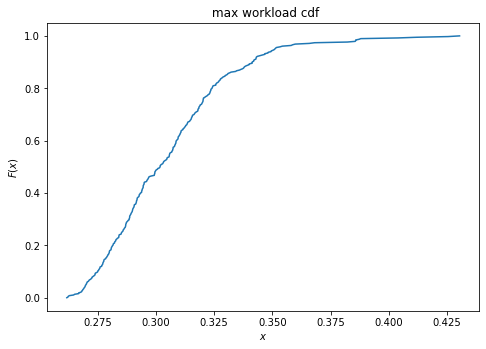

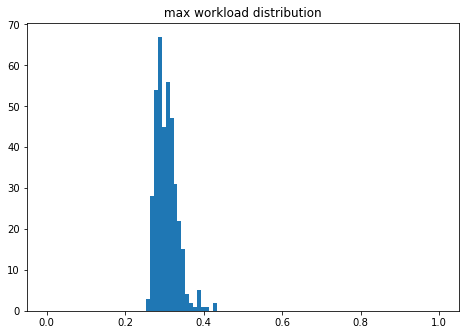

In [4]:
parallel_simulate(khop=2, batch_num=12 * 32, graph=graph, n_jobs=cpu_num)
print_results(n_jobs=12, save_file_name="plots/phm_2_384")

## Khop = 3

simulate using 12 cores


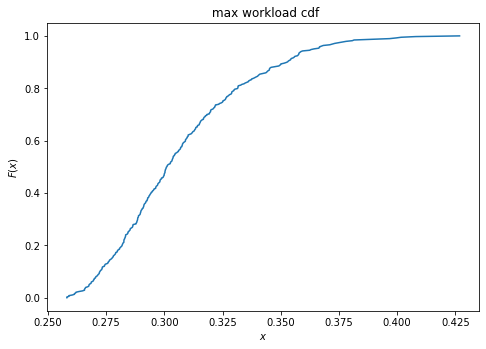

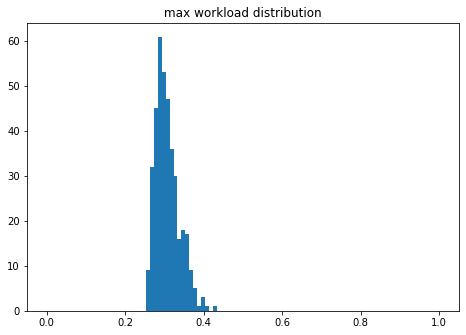

In [5]:
parallel_simulate(khop=3, batch_num=384, graph=graph, n_jobs=cpu_num)
print_results(n_jobs=12, save_file_name="plots/phm_3_384")

## Khop = 4

simulate using 12 cores


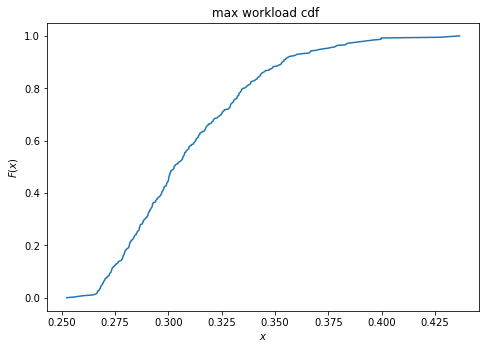

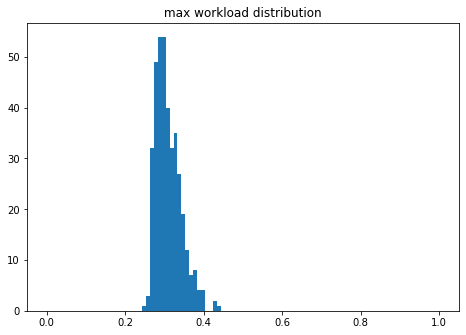

In [6]:
parallel_simulate(khop=4, batch_num=384, graph=graph, n_jobs=cpu_num)
print_results(n_jobs=12, save_file_name="plots/phm_4_384")

## Khop = 5

simulate using 12 cores


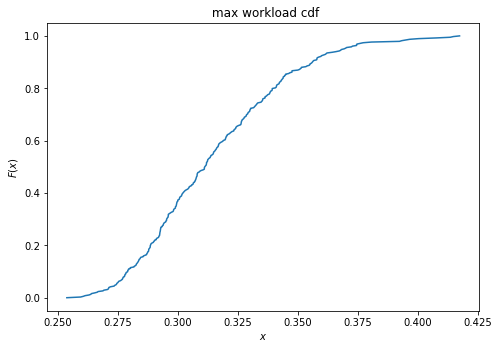

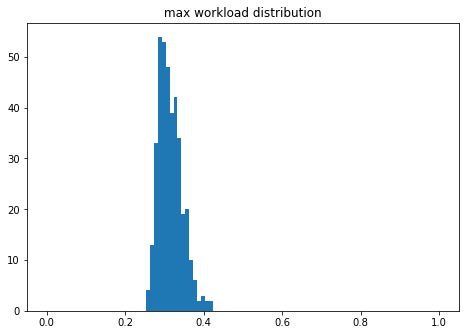

In [7]:
parallel_simulate(khop=5, batch_num=384, graph=graph, n_jobs=cpu_num)
print_results(n_jobs=12, save_file_name="plots/phm_5_384")